In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

DOMAIN = 'drink'
DB = 'postgres'

if DB == 'postgres':
    db_dict = {
        'test':   'postgres:///babble_model_unittest',
        'spouse': 'postgres:///babble_model_spouse',
        'bike':   'postgres:///babble_model_bike',
        'drink':   'postgres:///babble_model_drink',
        'cdr':    'postgres:///babble_model_cdr',
    }
    os.environ['SNORKELDB'] = db_dict[DOMAIN]
elif DB == 'sqlite':
    os.remove('snorkel.db')
    import shutil
    shutil.copy2('bike/snorkel.db', './')

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.contrib.babble.models import configuration

config = configuration
config['domain'] = DOMAIN
config['splits'] = [0,1]
config['babbler_split'] = 0
config['max_docs'] = None
config['parallelism'] = 1
config['traditional'] = False
config['majority_vote'] = False
config['verbose'] = True
config['display_marginals'] = True
config['display_accuracies'] = True
config['display_learned_accuracies'] = True

In [5]:
from snorkel.models import candidate_subclass
from tutorials.babble import MTurkHelper
from snorkel.contrib.babble import ExplanationIO

if DOMAIN == 'spouse':
    from tutorials.babble.spouse import SpouseModel
    Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
    candidate_class = Spouse
    
    expio = ExplanationIO()
    fpath = (os.environ['SNORKELHOME'] + 
        '/tutorials/babble/spouse/data/mturk_explanations_all.tsv')
    explanations = expio.read(fpath)
    
    sm = SpouseModel(session, Spouse, config)
elif DOMAIN == 'bike':
    from tutorials.babble.bike import BikeModel
    Biker = candidate_subclass('Biker', ['person', 'bike'])
    candidate_class = Biker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/bike/data/VisualGenome_all_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = BikeModel(session, Biker, config)
elif DOMAIN == 'drink':
    from tutorials.babble.drink import DrinkModel
    Drinker = candidate_subclass('Drinker', ['person', 'cup'])
    candidate_class = Drinker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/drink/data/Drink_VisualGenome_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = DrinkModel(session, Drinker, config)   
else:
    raise Exception('Invalid domain: {}'.format(DOMAIN))
user_lists = {}
print("Total explanations: {}".format(len(explanations)))

Reading train CSV!
Num HITs unique: 40
Num HITs total: 120
Unanimous: 111
Majority: 72
Bad: 13
Total explanations: 403


In [6]:
anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/drink/data/'
%time sm.parse(anns_folder)

Clearing existing...
Running UDF...
Running UDF...
CPU times: user 10.4 s, sys: 896 ms, total: 11.3 s
Wall time: 25.6 s


In [7]:
%time sm.extract()

Extraction was performed during parse stage.
Candidates [Split 0]: 2524
Candidates [Split 1]: 495
CPU times: user 12 ms, sys: 32 ms, total: 44 ms
Wall time: 32.1 ms


In [8]:
%time sm.load_gold(anns_folder)

Reading val CSV!
Num HITs unique: 124
Num HITs total: 372
Unanimous: 66
Majority: 464
Bad: 31
Reading train CSV!
Num HITs unique: 631
Num HITs total: 1262
Unanimous: 2264
Majority: 352
Bad: 84
AnnotatorLabels created: 464
AnnotatorLabels created: 2440
CPU times: user 50 s, sys: 1.42 s, total: 51.5 s
Wall time: 1min 2s


In [9]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_train

<2524x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2440 stored elements in Compressed Sparse Row format>

In [11]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<495x1 sparse matrix of type '<type 'numpy.int64'>'
	with 464 stored elements in Compressed Sparse Row format>

In [13]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_split']).all()
# candidates = session.query(candidate_class).filter(candidate_class.split == 0).all()
print(len(candidates))

2524


In [14]:
from snorkel.contrib.babble import link_explanation_candidates

explanations = link_explanation_candidates(explanations, candidates)

Building list of target candidate ids...
Collected 147 unique target candidate ids from 403 explanations.
Gathering desired candidates...
Found 147/147 desired candidates
Linking explanations to candidates...
Linked 403/403 explanations


In [15]:
%time sm.babble(explanations, user_lists=user_lists, config=config)

Calling babbler...
Created grammar with 430 rules
235 parses created from 155 out of 403 explanation(s)
Parsed 235 LFs from 403 explanations.
Filtered to 86 LFs with duplicate semantics filter (149 filtered).
Filtered to 43 LFs with consistency filter (43 filtered).
Clearing existing...
Running UDF...
[========================================] 100%

Filtered to 35 LFs with uniform signatures filter (8 filtered).
Filtered to 30 LFs with duplicate signatures filter (5 filtered).
CPU times: user 1min 13s, sys: 3.3 s, total: 1min 16s
Wall time: 2min 8s


In [16]:
sm.babbler.get_explanations()[:5]

[Explanation("Explanation12: False, Box Y is far right of center of Box X."),
 Explanation("Explanation122: False, BOX X IS BELOW THE BOX Y"),
 Explanation("Explanation128: False, Box X is not inside box Y"),
 Explanation("Explanation151: False, Box Y is much smaller than box X and top of Box Y is above top of Box X"),
 Explanation("Explanation16: False, BOX X IS FAR AWAY FROM THE BOX Y")]

In [17]:
sm.babbler.get_parses()[:5]

['return -1 if call(right(center(Box Y)), Box X) else 0',
 'return -1 if call(below(Box X), Box Y) else 0',
 'return -1 if not (call(within(Box X), Box Y)) else 0',
 "return -1 if (call(smaller(Box Y), Box X) and call(above(edge(Box Y, 'top')), edge(Box X, 'top'))) else 0",
 'return -1 if call(far(Box X), Box Y) else 0']

In [18]:
%time sm.label()

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (2524,30) sparse (nnz = 39998)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (495,30) sparse (nnz = 7858)
CPU times: user 1min 7s, sys: 3.06 s, total: 1min 10s
Wall time: 1min 48s


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
Explanation5_0,0,0.393939,0.393939,0.0,0,0,6,178,0.967391
Explanation12_2,1,0.573737,0.573737,0.0,0,0,5,260,0.981132
Explanation16_0,2,0.511111,0.511111,0.0,0,0,1,245,0.995935
Explanation21_0,3,0.101010,0.101010,0.0,0,0,0,47,1.000000
Explanation23_0,4,0.365657,0.365657,0.0,0,0,0,168,1.000000
Explanation24_0,5,0.622222,0.622222,0.0,0,0,1,287,0.996528
Explanation30_0,6,0.903030,0.903030,0.0,0,0,6,413,0.985680
Explanation32_2,7,0.488889,0.488889,0.0,0,0,4,222,0.982301
Explanation39_0,8,0.947475,0.947475,0.0,0,0,6,432,0.986301
Explanation40_0,9,0.088889,0.088889,0.0,0,0,1,38,0.974359


Inferred cardinality: 2


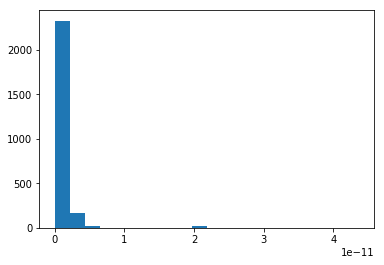

CPU times: user 52 s, sys: 6.66 s, total: 58.7 s
Wall time: 51.5 s


In [19]:
%time sm.supervise(config=config)
import time
time.sleep(5)

In [ ]:
L_dev = sm.labeler.load_matrix(session, split=1)
time.sleep(5)
L_dev

In [ ]:
L_dev.lf_stats(session, L_gold_dev)
time.sleep(5)

In [ ]:
tp, fp, tn, fn = sm.gen_model.error_analysis(session, L_dev, L_gold_dev)

In [ ]:
# %time sm.classify()

In [ ]:
# L_train = sm.labeler.load_matrix(session, split=0)
# L_train

In [ ]:
# # from snorkel.learning import GenerativeModel
# from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# epochs_param    = ListParameter('epochs', [5, 10, 20])
# decay_param     = ListParameter('decay', [0.9, 0.95])
# step_size_param = RangeParameter('step_size', 1e-6, 1e-5, step=1, log_base=10)
# reg_param       = ListParameter('reg_param', [1e-6])

# searcher = RandomSearch(GenerativeModel, 
#                         [step_size_param, decay_param, epochs_param, reg_param],
#                         L_train, n=5)

In [ ]:
# %%time
# gen_model_best, run_stats = searcher.fit(L_dev, L_gold_dev)
# run_stats

In [ ]:
# gen_model_best = GenerativeModel(class_prior=False, lf_prior=False, 
#                                  lf_propensity=False, lf_class_propensity=False)

In [ ]:
# gen_model_best.train(L_train, epochs=10, decay=0.95, step_size=1e-6, reg_param=1e-6)

In [ ]:
# tp, fp, tn, fn = gen_model_best.error_analysis(session, L_dev, L_gold_dev, b=0.8)

In [ ]:
# import matplotlib.pyplot as plt

# train_marginals = gen_model_best.marginals(L_train)
# plt.hist(train_marginals, bins=30)
# plt.show()